# Filtering Kepler LC for transit detection and analysis
Basic imports

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits as pyfits

Create class and function to read one Kepler LC and store data

In [2]:
class KeplerLC:
    def __init__(self):
        self.obj = None
        self.kid = None
        self.channel = None
        self.module = None
        self.quarter = None
        self.release = None
        self.obsmode = None
        self.BJDref = 2454833.0
        self.KBJD_start = None
        self.KBJD_end = None
        self.MBJD_start = None
        self.MBJD_end = None
        self.pdfcmethod = None
        self.numband = None
        self.fittype = None
        self.kbjd = None
        self.flux_sap = None
        self.eflux_sap = None
        self.flux_pdc = None
        self.eflux_pdc = None
        self.quality = None

def read_kepler_lc(fits_in):
    # init KeplerLC obj
    ko = KeplerLC()
    # open fits file
    hdu_in = pyfits.open(fits_in)
    # print summary
    hdu_in.info()
    # get PRIMARY HEADER
    hdr = hdu_in[0].header
    ko.obj = hdr['OBJECT']
    ko.kid = hdr['KEPLERID']
    ko.channel = hdr['CHANNEL']
    ko.module = hdr['MODULE']
    ko.quarter = hdr['QUARTER']
    ko.release = hdr['DATA_REL']
    ko.obsmode = hdr['OBSMODE']
    # get LC HEADER and DATA
    hdlc_h = hdu_in[1].header
    ko.KBJD_start = hdlc_h['TSTART']
    ko.KBJD_end = hdlc_h['TSTOP']
    ko.MJD_start = hdlc_h['LC_START']
    ko.MJD_end = hdlc_h['LC_END']
    ko.pdfcmethod = hdlc_h['PDCMETHD']
    ko.numband = hdlc_h['NUMBAND']
    ko.fittype = hdlc_h['FITTYPE%d' %(ko.numband)]
    hdlc_d = hdu_in[1].data
    ko.kbjd = hdlc_d['TIME']
    ko.flux_sap = hdlc_d['SAP_FLUX']
    ko.eflux_sap = hdlc_d['SAP_FLUX_ERR']
    ko.flux_pdc = hdlc_d['PDCSAP_FLUX']
    ko.eflux_pdc = hdlc_d['PDCSAP_FLUX_ERR']
    ko.quality = hdlc_d['SAP_QUALITY']
    hdu_in.close()
    print 'Before Remove NaN'
    print 'shape of flux_sap:', np.shape(ko.flux_sap)
    # remove NaN values
    rm_nan_sap = np.logical_or(np.isnan(ko.flux_sap), np.isnan(ko.eflux_sap)) == False
    rm_nan_pdc = np.logical_or(np.isnan(ko.flux_pdc), np.isnan(ko.eflux_pdc)) == False
    rm_nan = np.logical_or(rm_nan_sap, rm_nan_pdc)
    ko.kbjd = ko.kbjd[rm_nan]
    ko.flux_sap = ko.flux_sap[rm_nan]
    ko.eflux_sap = ko.eflux_sap[rm_nan]
    ko.flux_pdc = ko.flux_pdc[rm_nan]
    ko.eflux_pdc = ko.eflux_pdc[rm_nan]
    ko.quality = ko.quality[rm_nan]
    print 'After Remove NaN'
    print 'shape of flux_sap:', np.shape(ko.flux_sap)
    
    return ko

Provide fits file with path and read the file.

In [3]:
#folder = os.path.abspath('/home/borsato/Research/Kepler/Kepler-9/LC/2016-09-20_download/llc')
folder = os.path.abspath('/home/borsato/Dropbox/Research/Kepler/K9/LC/2017-09-20_download/R25/llc')
names = ['kplr003323887-2009166043257_llc.fits', 'kplr003323887-2009259160929_llc.fits']
fits_file = os.path.join(folder, names[0])
ko = read_kepler_lc(fits_file)

Filename: /home/borsato/Dropbox/Research/Kepler/K9/LC/2017-09-20_download/R25/llc/kplr003323887-2009166043257_llc.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      58   ()              
1    LIGHTCURVE  BinTableHDU    155   1639R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
2    APERTURE    ImageHDU        48   (5, 6)       int32   
Before Remove NaN
shape of flux_sap: (1639,)
After Remove NaN
shape of flux_sap: (1624,)


Plot LC SAP and PDC in flux with errors.

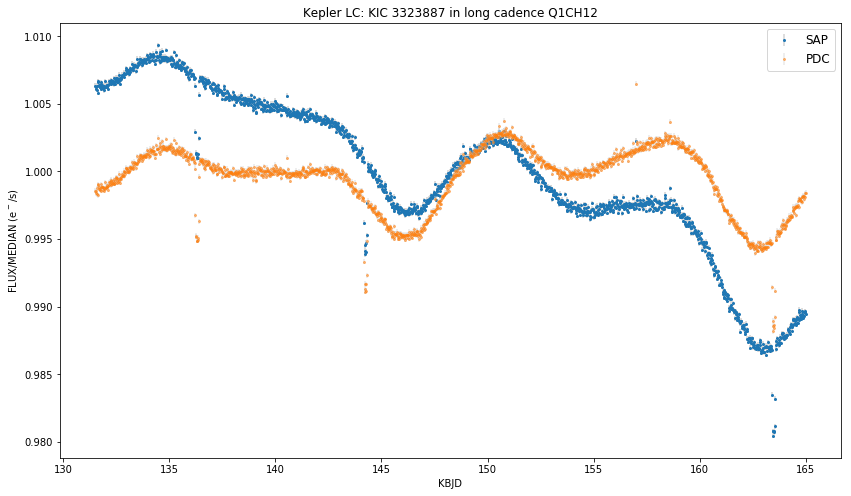

In [4]:
def plot_fluxes(ko):
    
    med_sap = np.median(ko.flux_sap)
    med_pdc = np.median(ko.flux_pdc)
    
    plt.figure(figsize=(14,8))
    ltitle = 'Kepler LC: %s in %s Q%sCH%s' %(ko.obj, ko.obsmode, str(ko.quarter), str(ko.channel))
    plt.title(ltitle)
    plt.errorbar(ko.kbjd, ko.flux_sap/med_sap, yerr=ko.eflux_sap/med_sap,
                 color='C0', marker='o', ms=2, ls='',
                 ecolor='lightgrey', capsize=0.,
                 label='SAP', zorder=6
                )
    plt.errorbar(ko.kbjd, ko.flux_pdc/med_pdc, yerr=ko.eflux_pdc/med_pdc,
                 color='C1', marker='o', ms=2, ls='',
                 ecolor='lightgrey', capsize=0.,
                 alpha=0.5,
                 label='PDC', zorder=7
                )
    plt.xlabel('KBJD')
    plt.ylabel('FLUX/MEDIAN (e$^-$/s)')
    plt.legend(loc='best', fontsize=12)

    return
# plot object data
plot_fluxes(ko)

Create a median filter fro fixed window.

In [5]:
def running_median(ko, flux_type = 'sap', win=1.):
    
    x = ko.kbjd
    if(flux_type == 'pdc'):
        y = ko.flux_pdc
    else:
        y = ko.flux_sap
       
    nx = np.shape(x)[0]
    z = np.ones((nx)) # filtered output
    xmin, xmax = np.min(x), np.max(x)
    hwin = 0.5*win
    for ix in range(0, nx):
        xs = x[ix]-hwin
        xe = x[ix]+hwin
        # first attempt to manage the starting/ending windows --> to be improved
        # 1) simple: take xmin/xmax as new lower/upper limits
        #if (xs < xmin):
        #    xs = xmin
        #elif(xe > xmax):
        #    xe = xmax 
        # 2) costant: take x[ix] values, counts how many points gt/lt x[ix] (nupper/nlower)
        #    and create nnew lower/upper missing values with y[ix] value
        if (xs < xmin):
            nup = int(np.sum(np.logical_and(x > x[ix], x <= xe)))
            nlow = int(np.sum(np.logical_and(x >= xs, x < x[ix])))
            nnew = int(np.abs(nup - nlow))
            #print 'xs < xmin: ', nup, nlow, nnew
            ylow = np.zeros((nnew)) + y[ix]
            selx = np.logical_and(x >= xs, x <= xe)
            ysel = np.hstack((ylow, y[selx]))
            nsel = np.shape(ysel)[0]
        elif(xe > xmax):
            nup = int(np.sum(np.logical_and(x > x[ix], x <= xe)))
            nlow = int(np.sum(np.logical_and(x >= xs, x < x[ix])))
            nnew = int(np.abs(nlow - nup))
            #print 'xe > xmax: ', nup, nlow, nnew
            yup = np.zeros((nnew)) + y[ix]
            selx = np.logical_and(x >= xs, x <= xe)
            ysel = np.hstack((y[selx], yup))
            nsel = np.shape(ysel)[0]
        else:
            selx = np.logical_and(x >= xs, x <= xe)
            nsel = int(np.sum(selx))
            if (nsel > 0): ysel = y[selx]
            
        if(nsel >0):
            z[ix] = np.median(ysel)
        else:
            z[ix] = np.nan
    
    return z

In [6]:
# prepare plot of flux and overplotted filter
def plot_flux_filter(ko, flux_filter, xlmin_in, xlmax_in, flux_type='sap', win=1., kclip=5.):
    
    if(flux_type == 'pdc'):
        flux = ko.flux_pdc
        eflux = ko.eflux_pdc
    else:
        flux = ko.flux_sap
        eflux = ko.eflux_sap
    med = np.median(flux)
   
    if(xlmin_in is None):
        xlmin = np.min(ko.kbjd)
    else:
        xlmin = xlmin_in
    if(xlmax_in is None):
        xlmax = np.max(ko.kbjd)
    else:
        xlmax = xlmax_in
        
    nflux = flux/med
    neflux = eflux/med
    nflux_filter = flux_filter/med
    rflux = nflux - nflux_filter
    rmed = np.median(rflux)
    rms = np.percentile(np.abs(rflux-rmed), 68.27, interpolation='midpoint')
    sel_to_keep = np.abs(rflux) < rmed + kclip*rms
    rmed_keep = np.median(rflux[sel_to_keep])
    rms_clip = np.percentile(np.abs(rflux[sel_to_keep]-rmed_keep), 68.27, interpolation='midpoint')

    plt.figure(figsize=(14,8))
    ltitle = 'Kepler LC: %s in %s Q%sCH%s ==> rms(flux-filter) = %.4f ppm -> %.4f ppm (%d-$\sigma$ clipped)' \
            %(ko.obj, ko.obsmode, str(ko.quarter), str(ko.channel), rms*10**6, rms_clip*10**6, kclip)
    plt.title(ltitle)
    plt.errorbar(ko.kbjd, nflux, yerr=neflux,
                 color='C0', marker='o', ms=2, ls='',
                 ecolor='lightgrey', capsize=0.,
                 label=flux_type.upper(), zorder=6
                )
    plt.plot(ko.kbjd, nflux_filter,
             color='C1', marker='o', ms=2, ls='',
             alpha=0.5,
             label='FILTER (WINDOW = %.2f days)' %(win), zorder=7
            )
    
    rshift = np.min(nflux)-0.005
    plt.plot(ko.kbjd, rflux+rshift,
             color='C2', marker='o', ms=2, ls='',
             alpha=1.,
             label='residuals (shifted)', zorder=8
            )
    plt.plot(ko.kbjd[sel_to_keep], rflux[sel_to_keep]+rshift,
             color='C3', marker='o', ms=3, ls='',
             alpha=1.,
             label='residuals < %d-$\sigma$ (shifted)' %(kclip), zorder=9
            )
    plt.axhspan(rmed-kclip*rms + rshift, rmed+kclip*rms + rshift,
                color='C3',
                alpha=0.3, zorder = 7
               )
    
    plt.xlim([xlmin, xlmax])
    plt.xlabel('KBJD')
    plt.ylabel('FLUX/MEDIAN (e$^-$/s)')
    plt.legend(loc='best', fontsize=12)
    
    return sel_to_keep

TEST MEDIAN FILTER: WIN = 1.000


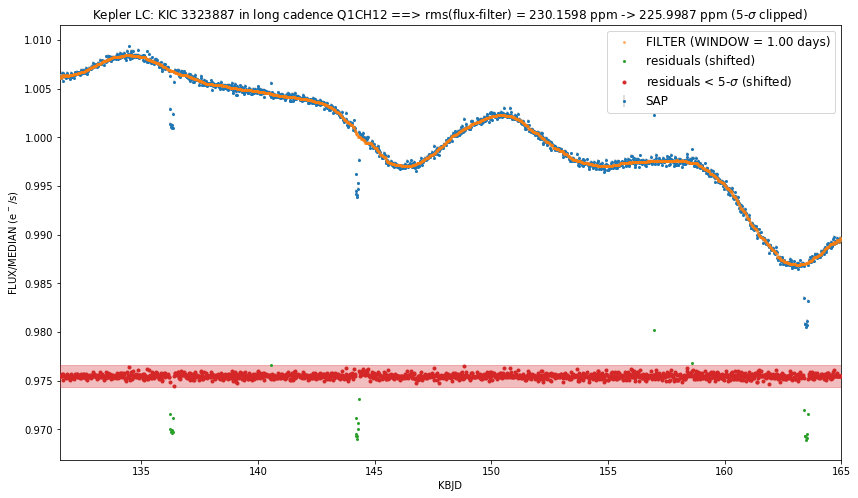

In [7]:
# testing running median
choose_ftype, win_filter = 'sap', [1.]
ntest = len(win_filter)
flux_filters = []
xlmin, xlmax = None, None #144., 148. #
for ii in range(0, ntest):
    print 'TEST MEDIAN FILTER: WIN = %.3f' %(win_filter[ii])
    flux_filter = running_median(ko, flux_type=choose_ftype, win=win_filter[ii])
    sel_to_keep = plot_flux_filter(ko, flux_filter, xlmin, xlmax,
                                   flux_type=choose_ftype, win=win_filter[ii], kclip=5
                                  )
    flux_filters.append(flux_filter)

Test GP with scikit-learn

In [8]:
# from example
#from sklearn.gaussian_process import GaussianProcessRegressor as GPR
#from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# my test
import sklearn.gaussian_process as sgp

In [14]:
def do_gp(ko, sel_to_keep):
    kc = sgp.kernels.ConstantKernel(constant_value=1.0)
    kRBF = sgp.kernels.RBF(length_scale=2.0,
                           length_scale_bounds=(0.8, 10.)
                          ) # hope bounds in days ...
    kcRBF = kc*kRBF
    print 'KERNEL INIT'
    xgp = np.atleast_2d(ko.kbjd).T
    xgp_sel = np.atleast_2d(ko.kbjd[sel_to_keep]).T

    med = np.median(ko.flux_sap[sel_to_keep])
    nflux_sel = ko.flux_sap[sel_to_keep]/med
    neflux_sel = ko.eflux_sap[sel_to_keep]/med
    nflux = ko.flux_sap/med
    neflux = ko.eflux_sap/med
#     yalpha= ko.eflux_sap[sel_to_keep]/ko.flux_sap[sel_to_keep]
    yalpha = neflux_sel
    
    gp = sgp.GaussianProcessRegressor(kernel=kcRBF, 
                                      alpha=yalpha**2,
                                      n_restarts_optimizer=5
                                     )
    print 'GPR INIT'
    gp.fit(xgp_sel, nflux_sel)
    print 'GP FIT DONE'
    flux_pred, flux_sigma = gp.predict(xgp, return_std=True)
    print 'GP PREDICT DONE'
    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE

    ymin = np.min(nflux)
    ymax = np.max(nflux)
    ydelta = np.abs(ymax-ymin)
    ylmin = ymin - ydelta*0.05
    ylmax = ymax + ydelta*0.05
    
    plt.figure(figsize=(14,8))
    plt.errorbar(ko.kbjd, nflux, yerr=neflux,
                 color='grey', marker='o', ms=1, ls='',
                 ecolor='lightgrey', capsize=0.,
                 label='FULL SAP', zorder=6
                )
    plt.errorbar(xgp_sel, nflux_sel, yerr=neflux_sel,
             color='C0', marker='o', ms=3, ls='',
             ecolor='lightgrey', capsize=0.,
             label='SAP USED IN GP', zorder=7
            )
    plt.plot(xgp, flux_pred,
             color='C1', marker='', ls='-', lw=1.5,
             alpha=1.,
             label='GP prediction', zorder=8
            )

    plt.fill(np.concatenate([xgp, xgp[::-1]]),
            np.concatenate([flux_pred - 3. * flux_sigma,
                           (flux_pred + 3. * flux_sigma)[::-1]]),
            alpha=.5, fc='C1', ec='None',
            label='3-$\sigma$ interval', zorder=6
           )
    
    plt.ylim([ylmin, ylmax])
    plt.xlabel('KBJD')
    plt.ylabel('FLUX/MEDIAN (e$^-$/s)')
    
    plt.legend(loc='best', fontsize=12)
    
    # compute the new full corrected flux and plot
    
    nflux_cor = nflux / flux_pred
    plt.figure(figsize=(14,8))
    plt.errorbar(ko.kbjd, nflux_cor, yerr=neflux,
                 color='C0', marker='o', ms=2, ls='',
                 ecolor='lightgrey', capsize=0.,
                 label='CORRECTED SAP', zorder=6
                )
    
    plt.xlabel('KBJD')
    plt.ylabel('FLUX/MEDIAN (e$^-$/s)')
    
    plt.legend(loc='best', fontsize=12)
    
    return nflux_cor

KERNEL INIT
GPR INIT
GP FIT DONE
GP PREDICT DONE


/home/borsato/anaconda/envs/anapy2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 8.68017578,  5.60428113]), 'nit': 8, 'funcalls': 54}
  " state: %s" % convergence_dict)


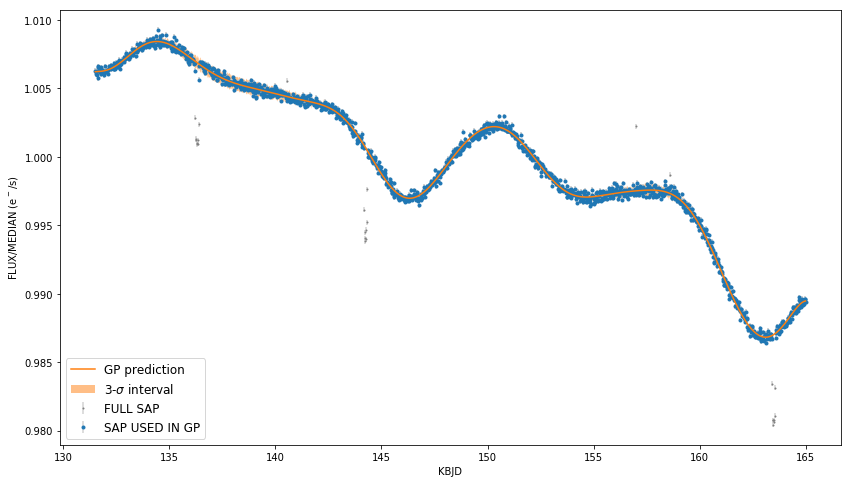

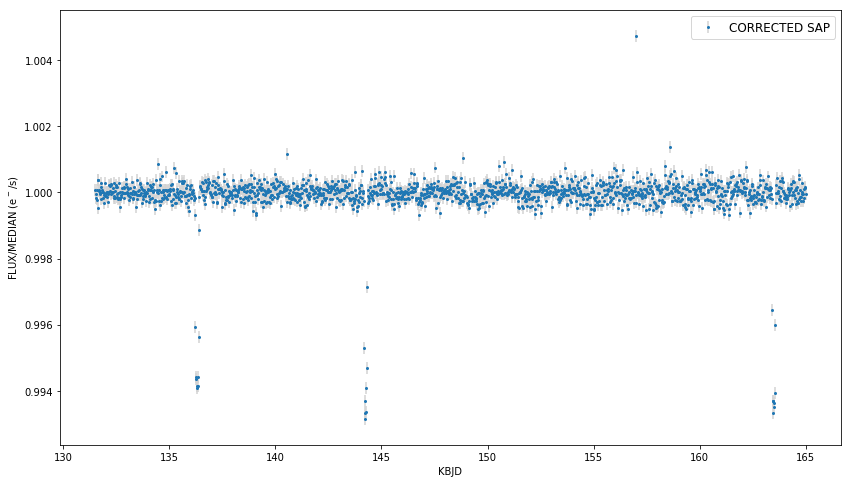

In [15]:
nflux_cor = do_gp(ko, sel_to_keep)